In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import edward as ed
import tensorflow as tf
plt.style.use('bmh')

Temp (F), O-Ring failure?
[[ -1.   0.]
 [  3.   1.]
 [  2.   0.]
 [  1.   0.]
 [  0.   0.]
 [  5.   0.]
 [  6.   0.]
 [  3.   0.]
 [-10.   1.]
 [ -4.   1.]
 [  3.   1.]
 [ 11.   0.]
 [  0.   0.]
 [-14.   1.]
 [  0.   0.]
 [  8.   0.]
 [  3.   0.]
 [ 14.   0.]
 [  9.   0.]
 [ 12.   0.]
 [  8.   1.]
 [  9.   0.]
 [ -9.   1.]]


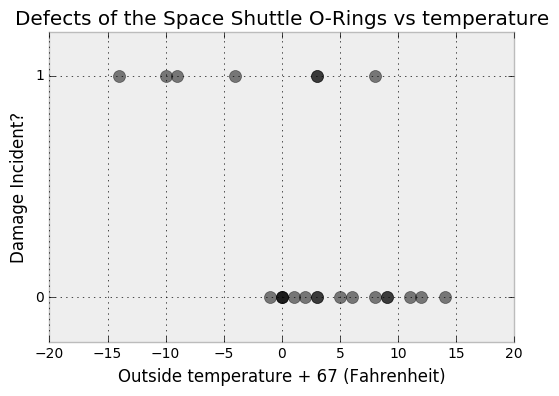

In [2]:
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]
challenger_data[:,0] = challenger_data[:,0]-67
#plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)
plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature + 67 (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

In [3]:
def logistic(x,beta,alpha=0):
    return 1.0 / (1.0+tf.exp(ed.dot(x,beta)+alpha))

In [5]:
temperature = challenger_data[:,0]
t_temp = np.reshape(np.float32(challenger_data[:,0]),[-1,1])
D = challenger_data[:,1]
t_D = np.squeeze(np.reshape(np.float32(challenger_data[:,1]),[-1,1]))

#beta = ed.models.Normal(loc=tf.random_normal([1,1],0,1),scale=tf.random_normal([1,1],0,1))
#alpha = ed.models.Normal(loc=tf.random_normal([1],0,1),scale=tf.random_normal([1],0,1))
#p = logistic(t_temp,beta,alpha)

In [6]:
qbeta = ed.models.Normal(loc=tf.Variable(tf.random_normal([1,1],0,1)),scale=tf.Variable(tf.random_normal([1,1],0,1)))
qalpha = ed.models.Normal(loc=tf.Variable(tf.random_normal([1],0,1)),scale=tf.Variable(tf.random_normal([1],0,1)))

qbeta = ed.models.Empirical(params=tf.zeros([100]))
qalpha = ed.models.Empirical(params=tf.zeros([100]))
proposal_beta = ed.models.Normal(loc=beta, scale=0.5)
proposal_alpha = ed.models.Normal(loc=alpha, scale=0.5)

In [27]:
X = tf.placeholder(tf.float32, [23, 1])
w = ed.models.Normal(loc=tf.random_normal([1],0,1), scale=tf.random_normal([1],0,1))
b = ed.models.Normal(loc=tf.random_normal([1],0,1), scale=tf.random_normal([1],0,1))
y = logistic(X,w,b)
#y = ed.models.Bernoulli(probs=logistic(X,w,b), dtype=tf.float32)

qw = ed.models.Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb = ed.models.Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [28]:
inputs = np.linspace(-20, 20, num=400, dtype=np.float32)
x = tf.expand_dims(inputs, 1)
mus = tf.stack(
    [logistic(x,w,b)
     for _ in range(10)])
mus=tf.reshape(mus,[10,400])

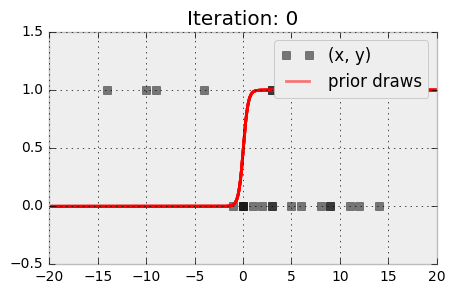

In [29]:
# FIRST VISUALIZATION (prior)

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(temperature, D, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-20, 20])
ax.set_ylim([-0.5, 1.5])
ax.legend()
plt.show()

In [31]:
print(w.eval())
print(b.eval())

[-3.58021641]
[ 1.88397276]


In [33]:
inference = ed.KLqp({w:qw, b:qb},{X:t_temp,y:t_D})

inference.run(n_iter=100000, n_samples=100)

100000/100000 [100%] ██████████████████████████████ Elapsed: 137s | Loss: 46.681


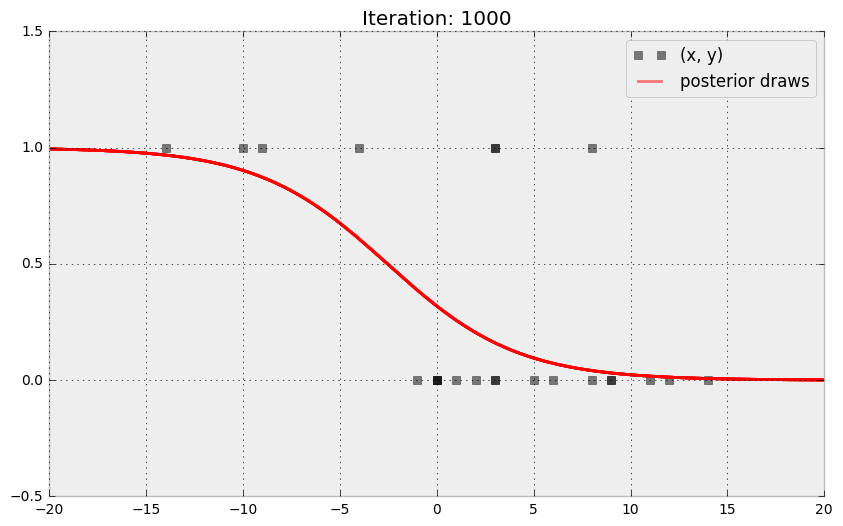

In [34]:
# SECOND VISUALIZATION (posterior)

outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")
ax.plot(temperature, D, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-20, 20])
ax.set_ylim([-0.5, 1.5])
ax.legend()
plt.show()

In [35]:
print(w.eval())
print(b.eval())

[-0.99496394]
[-1.08098876]
